<a href="https://colab.research.google.com/github/Easytech/AI-POC/blob/main/EZEnergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Import libraries and data

In [ ]:
# General libraries
import numpy as np
import os
import pandas as pd 
import unicodedata
import datetime
import random
import datetime
from datetime import datetime
from datetime import timedelta
import math
import glob
from math import sqrt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
# AI libraries:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('AI_UtilityData_Format_Sample.csv', sep=',',encoding='utf-8', decimal=',')

FileNotFoundError: ignored

# 2) Pre-process the data

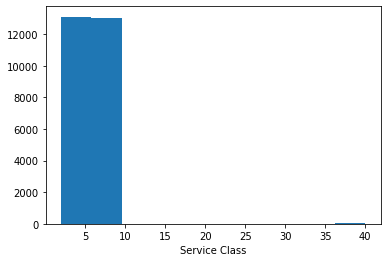

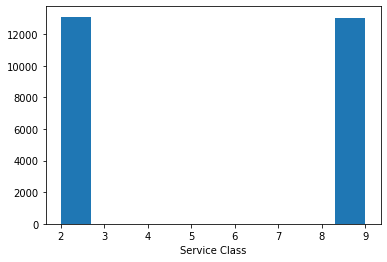

In [ ]:
# We see isolated events with Service Class = 40
# We discard them because fot this project they provide confussion rather than contribution
plt.hist(data['Service Class'].tolist())
plt.xlabel("Service Class")
plt.show()
data.drop(data[data['Service Class'] > 20].index, inplace=True)
plt.hist(data['Service Class'].tolist())
plt.xlabel("Service Class")
plt.show()

In [ ]:
# We find a few NaN (Not a Number) in column Cost, we drop them
print(data.shape)
data = data[data['Cost'].notna()]
data.shape

(26110, 8)


(26002, 8)

In [ ]:
# Create two new columns to assign the anomaly indicators for the two methods we'll proceed
data['anomaly_linear']=0.0
data['anomaly_auto-encoder']=0.0

# Convert the date columns to correct datetime format, and create one new column that has the month of the start date 
# (since all periods are ~ 1 month, this is enough)
data['end'] = pd.to_datetime(data['End Date'],format="%d/%m/%Y",)
data['end'] = data['end'].dt.date

data['start'] = pd.to_datetime(data['Start Date'],format="%d/%m/%Y",)
data['start'] = data['start'].dt.date

data['month'] = pd.DatetimeIndex(data['start']).month

In [ ]:
# We must design the NN architecture accordingly to the symmetries of the problem
# In this case months are similar as we apart from July (for instance May is similar to October)
# and also there a periodic symmetry (December is close to January).
# Therefore we convert the month number into a month code that summarizes this fact
# by computing the difference in absolute value to month 7,
data['month_code'] = data['month'].map(lambda x: abs(x-7))
[["Real month="+str(i),"Assign it to number "+str(abs(i-7))] for i in range(1,13)]

[['Real month=1', 'Assign it to number 6'],
 ['Real month=2', 'Assign it to number 5'],
 ['Real month=3', 'Assign it to number 4'],
 ['Real month=4', 'Assign it to number 3'],
 ['Real month=5', 'Assign it to number 2'],
 ['Real month=6', 'Assign it to number 1'],
 ['Real month=7', 'Assign it to number 0'],
 ['Real month=8', 'Assign it to number 1'],
 ['Real month=9', 'Assign it to number 2'],
 ['Real month=10', 'Assign it to number 3'],
 ['Real month=11', 'Assign it to number 4'],
 ['Real month=12', 'Assign it to number 5']]

In [ ]:
print(data.shape)
data[:5]

(26002, 14)


,Meter Consumption ID,Start Date,End Date,Usage,Cost,Estimated Value (Yes/No),Service Class,ICAP,anomaly_linear,anomaly_auto-encoder,end,start,month,month_code
0,130,06/03/2014,07/04/2014,295,45.70,No,2,0.779,0.0,0.0,2014-04-07,2014-03-06,3,4
1,130,07/04/2014,06/05/2014,251,39.40,No,2,0.779,0.0,0.0,2014-05-06,2014-04-07,4,3
2,130,06/05/2014,05/06/2014,249,27.08,No,2,0.779,0.0,0.0,2014-06-05,2014-05-06,5,2
3,130,05/06/2014,07/07/2014,257,27.95,No,2,0.779,0.0,0.0,2014-07-07,2014-06-05,6,1
4,130,07/07/2014,05/08/2014,236,23.36,No,2,0.779,0.0,0.0,2014-08-05,2014-07-07,7,0


# 3) Anomaly 1: Linear fit month-a-month and detect anomalies by fit 

In this case we understand all the data features and their relationship, therefore we can tackle
the problem from this point of view.  However, we'll only find the anomalies that we are looking for.

In [ ]:
# Define a linear function to fit, in this case a straight line
def func(X, m,b):
    x = X
    return m * x + b

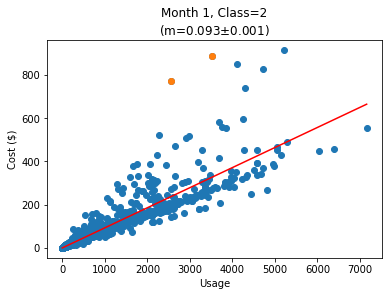

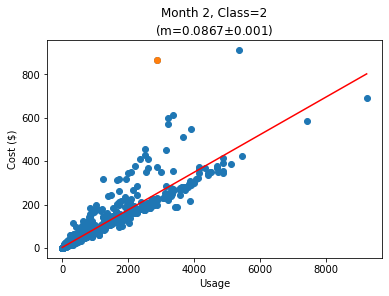

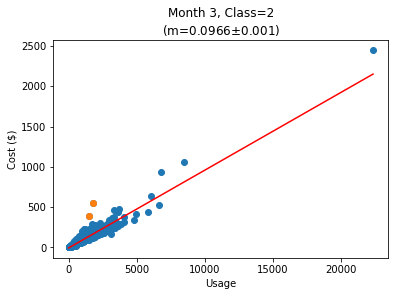

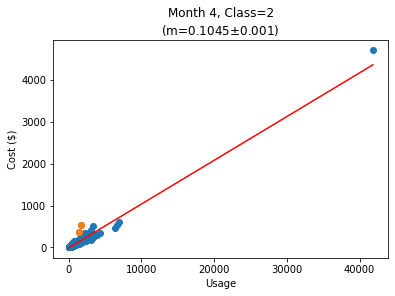

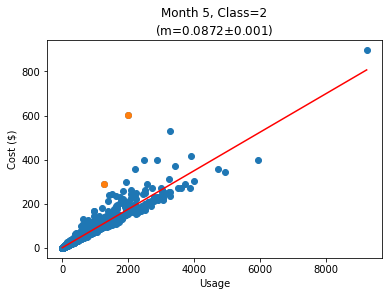

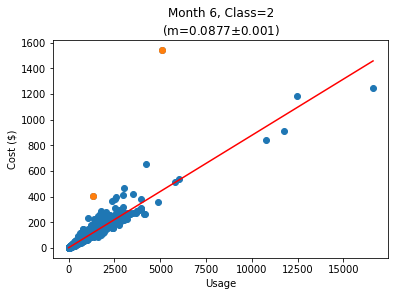

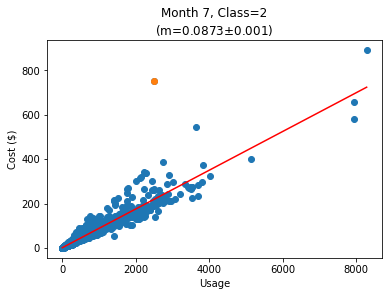

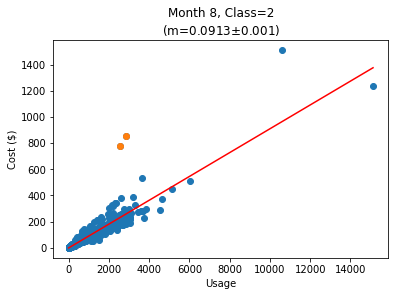

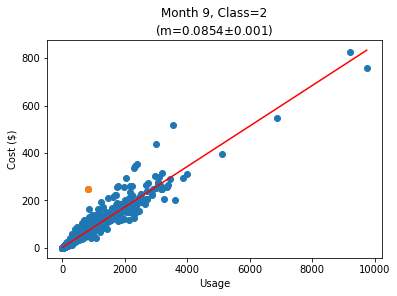

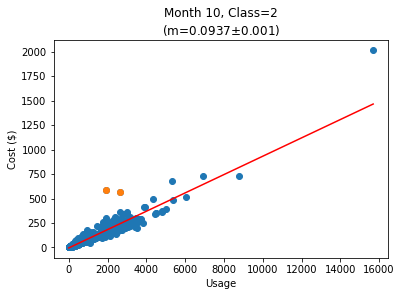

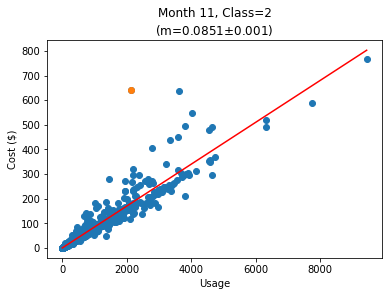

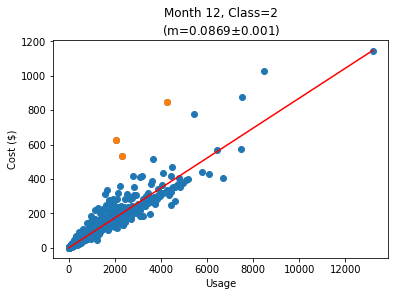

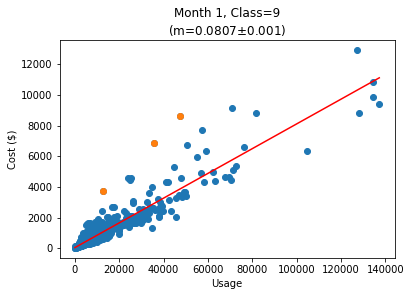

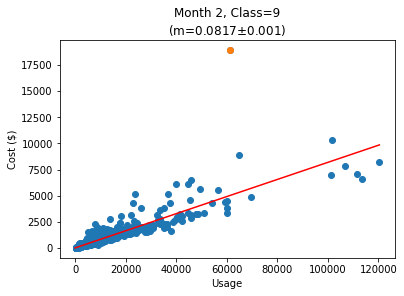

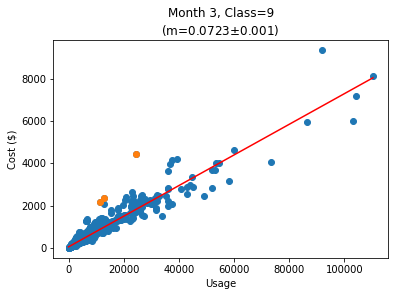

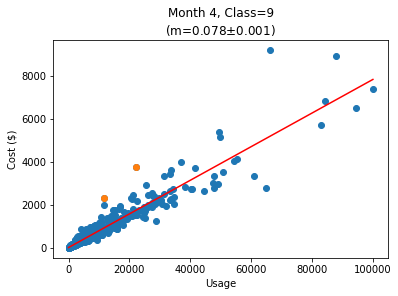

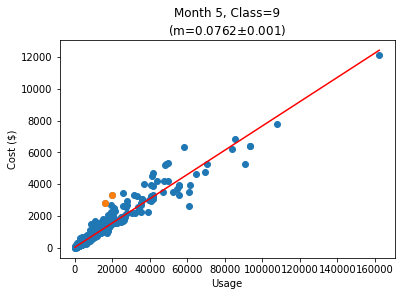

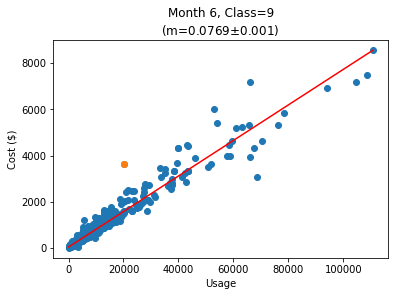

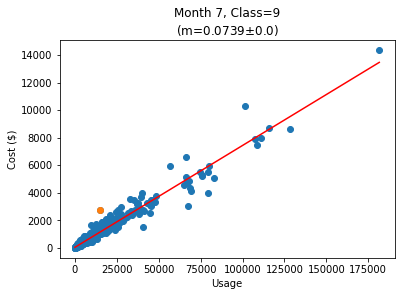

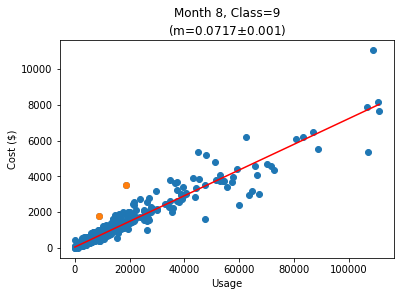

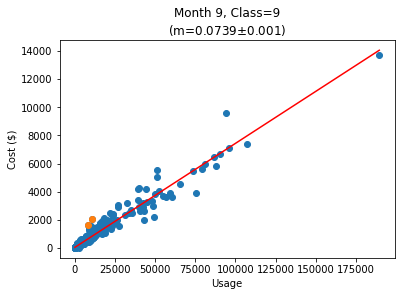

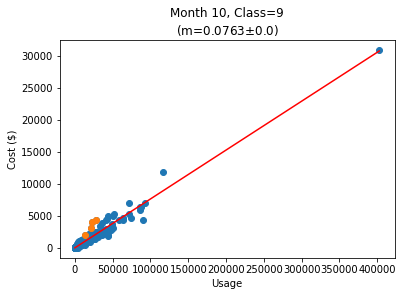

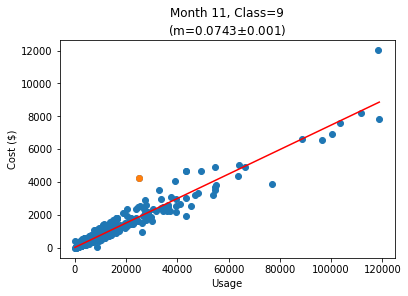

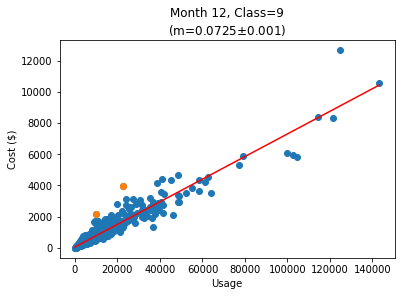

In [ ]:
# we run all classes and all months
for Class in [2,9]:
    for month in range(1,13):
        my_mask = data['start'].map(lambda x: x.month) == month
        test = data[my_mask]
        test = test.loc[test['Service Class']==Class]   
        usage = test['Usage'].tolist()
        cost = test['Cost'].tolist()
        testindex = test.index.tolist()
        # fit
        y= np.array(cost)
        x = np.array(usage)
        xmax = np.max(x)
        h1, h1cov = curve_fit(func, x, y)    
        m = h1[0]
        b = h1[1]
        Dm = math.sqrt(h1cov[0][0])
        Db = math.sqrt(h1cov[1][1])
        # Find anomalous points
        anomalousx = []
        anomalousy = []
        for i in range(len(cost)):
            estimated = usage[i] * m + b  # We estimate cost in each point using the fit for all points
            s = abs( estimated - cost[i] ) / math.sqrt((usage[i]*Dm)**2+(Db)**2)  # This is the significance: the difference between estimation and real cost, in units of the standard deviation
            data['anomaly_linear'][testindex[i]] = s  # We add to each row the value of the significance as the anomaly indicator for method 1
            if s > 100:  # We keep this anomalous points to plot them with different color in the visualization
                anomalousx.append(usage[i])
                anomalousy.append(cost[i])        
        # We plot month-a-month, and for each class the visual result of the anomalous datapoints
        # thath we found through this first "hand-made" method 
        #(which is only possible because the data is extremely simple)
        plt.scatter(usage,cost)    
        plt.scatter(anomalousx,anomalousy)    
        plt.plot([0,xmax],[0+h1[1],h1[0]*xmax+h1[1]],'r-')
        plt.title('Month '+str(month)+', Class='+str(Class)+'\n(m='+str(round(h1[0],4))+'$\pm$'+str(round(Dm,3))+')')
        plt.xlabel('Usage')
        plt.ylabel('Cost ($)')
        plt.savefig('month='+str(month)+'_service-class='+str(Class)+'.png')
        plt.show()

In [ ]:
# We check that we have correctly filled the column 'anomaly_linear'
data[:5]

,Meter Consumption ID,Start Date,End Date,Usage,Cost,Estimated Value (Yes/No),Service Class,ICAP,anomaly_linear,anomaly_auto-encoder,end,start,month,month_code
0,130,06/03/2014,07/04/2014,295,45.70,No,2,0.779,21.712066,0.0,2014-04-07,2014-03-06,3,4
1,130,07/04/2014,06/05/2014,251,39.40,No,2,0.779,25.594821,0.0,2014-05-06,2014-04-07,4,3
2,130,06/05/2014,05/06/2014,249,27.08,No,2,0.779,4.451905,0.0,2014-06-05,2014-05-06,5,2
3,130,05/06/2014,07/07/2014,257,27.95,No,2,0.779,2.158141,0.0,2014-07-07,2014-06-05,6,1
4,130,07/07/2014,05/08/2014,236,23.36,No,2,0.779,1.481306,0.0,2014-08-05,2014-07-07,7,0


# 4) Anomaly 2: Auto-encoder to detect anomalies

In this case the AI algorithm will learn the data pattern and detect anomalies. The idea is that it will detect not only the anomalies that we know that exist, but also others.  After an auto-encoder algorithm passes through, one has to analyze many aspect which are no trivial to understand which were the relevant features the auto-encoder detected to define anomalous data-points.

In [ ]:
# Let's first shuffle the data to avoid bias in learning
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(drop=True, inplace=True)
data[:5]

,Meter Consumption ID,Start Date,End Date,Usage,Cost,Estimated Value (Yes/No),Service Class,ICAP,anomaly_linear,anomaly_auto-encoder,end,start,month,month_code
0,1073,14/06/2016,14/07/2016,2520,192.53,No,2,1.7158,8.842146,0.0,2016-07-14,2016-06-14,6,1
1,4345,03/01/2019,04/02/2019,39,2.99,No,2,0.0799,0.080751,0.0,2019-02-04,2019-01-03,1,6
2,5176,26/02/2020,26/03/2020,1093,87.33,Yes,2,5.0245,4.465644,0.0,2020-03-26,2020-02-26,2,5
3,892,11/12/2014,12/01/2015,25280,2525.47,No,9,27.5189,35.379633,0.0,2015-01-12,2014-12-11,12,5
4,6849,04/08/2016,02/09/2016,2010,151.45,No,2,5.0672,11.419548,0.0,2016-09-02,2016-08-04,8,1


,Meter Consumption ID,Start Date,End Date,Usage,Cost,Estimated Value (Yes/No),Service Class,ICAP,anomaly_linear,anomaly_auto-encoder,end,start,month,month_code
0,1073,14/06/2016,14/07/2016,2520,192.53,No,2,1.7158,8.842146,0.0,2016-07-14,2016-06-14,6,1
1,4345,03/01/2019,04/02/2019,39,2.99,No,2,0.0799,0.080751,0.0,2019-02-04,2019-01-03,1,6
2,5176,26/02/2020,26/03/2020,1093,87.33,Yes,2,5.0245,4.465644,0.0,2020-03-26,2020-02-26,2,5


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                

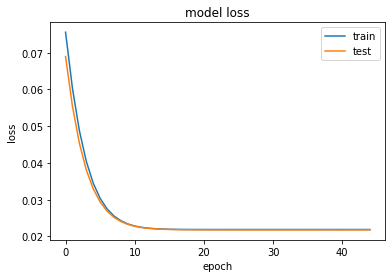

Class = 2:  (13091, 14)


,Meter Consumption ID,Start Date,End Date,Usage,Cost,Estimated Value (Yes/No),Service Class,ICAP,anomaly_linear,anomaly_auto-encoder,end,start,month,month_code
3,892,11/12/2014,12/01/2015,25280,2525.47,No,9,27.5189,35.379633,0.0,2015-01-12,2014-12-11,12,5
6,6338,24/06/2015,24/07/2015,5400,483.73,No,9,10.8470,3.486600,0.0,2015-07-24,2015-06-24,6,1
7,8738,07/01/2016,08/02/2016,2520,427.35,No,9,1.6320,11.687207,0.0,2016-02-08,2016-01-07,1,6


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                

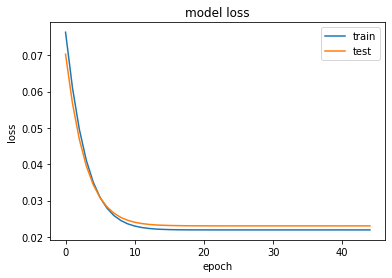

Class = 9:  (12911, 14)


In [ ]:
for Class in [2,9]:  # We compute them separately because these tags do not represent continuous relevant info
    selected_data = data.loc[(data['Service Class']== Class)]
    # To optimize any training one should design the NN taking profit of the symmetries of the problem.
    # In this case this correspond to select the relevant features and correctly codified to improve the learning
    training_data = selected_data.filter(['Usage','Cost','Service Class','month_code'], axis=1)
    display(selected_data[:3])
    # Divide the dataset in learning and testing, which is crucial to verify no overfitting
    f=len(training_data)
    f0 = int(0.75*f)
    # Scale to (0,1) all numbers in dataframe, since NN work optimized for this range of real numbers
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(training_data)
    # Divide in train and test:
    X_train = scaled_data[:f0]  
    X_test = scaled_data[f0:]
    # Specific learning features
    nb_epoch = 45
    batch_size = 128
    # We create the auto-encoder layer by layer:
    # Create first layer that receives each scaled_seq
    input_layer = Input(shape=(4, ))
    # Pass it to a first layer and encode 
    encoder = Dense(4, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(3, activation="relu")(encoder)
    encoder = Dense(3, activation="relu")(encoder)
    encoder = Dense(2, activation="relu")(encoder)
    encoder = Dense(1, activation="relu")(encoder)
    # start decoder
    decoder = Dense(2, activation='relu')(encoder)
    decoder = Dense(3, activation='relu')(decoder)
    decoder = Dense(4, activation='tanh')(decoder)
    # Physically create the auto-encoder model
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    # Show autoencoder NN
    autoencoder.summary()
    # We now train it
    autoencoder.compile(optimizer='adam', 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                                   verbose=0,
                                   save_best_only=True)

    tensorboard = TensorBoard(log_dir='./logs',
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)

    history = autoencoder.fit(X_train, X_train,   # <---- THIS IS THE *KEY* LINE THAT DEFINES THAT IS AN AUTOENCODER!
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_test, X_test),
                        verbose=1,
                        callbacks=[checkpointer, tensorboard]).history
    print(f'Min Loss:{np.min(history["loss"])}')
    # We plot the loss function for train and test sets to verify there is no over-fitting
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # Get the MSE error term 
    # Compute its logarithm to improve visualization of small numbers
    predictions = autoencoder.predict(scaled_data)
    mse = np.log10(np.mean(np.power(scaled_data - predictions, 2), axis=1))
    # Include the mse values as the anomaly indicators for the auto-encoder method
    selected_data['anomaly_auto-encoder'] = mse
    # Save the data for analyzing below
    if Class == 2:
        out2 = selected_data.copy()
        print('Class = 2: ', out2.shape)
    if Class == 9:
        out9 = selected_data.copy()
        print('Class = 9: ', out9.shape)


# 5) Compare the two methods side-by-side

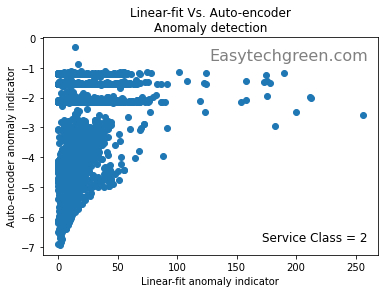

In [ ]:
# Class = 2
plt.scatter(out2['anomaly_linear'].tolist(),out2['anomaly_auto-encoder'].tolist())
plt.xlabel('Linear-fit anomaly indicator')
plt.ylabel('Auto-encoder anomaly indicator')
plt.title('Linear-fit Vs. Auto-encoder\nAnomaly detection')
plt.text(.97,.95,'Easytechgreen.com',ha='right',va='top', fontsize=16, color='gray',transform = plt.gca().transAxes)
plt.text(.97,.05,'Service Class = 2',ha='right',va='bottom', fontsize=12, color='black',transform = plt.gca().transAxes)
plt.savefig('correlation_class=2.png')
plt.show()

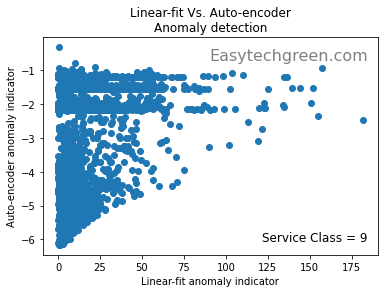

In [ ]:
# Class = 2
plt.scatter(out9['anomaly_linear'].tolist(),out9['anomaly_auto-encoder'].tolist())
plt.xlabel('Linear-fit anomaly indicator')
plt.ylabel('Auto-encoder anomaly indicator')
plt.title('Linear-fit Vs. Auto-encoder\nAnomaly detection')
plt.text(.97,.95,'Easytechgreen.com',ha='right',va='top', fontsize=16, color='gray',transform = plt.gca().transAxes)
plt.text(.97,.05,'Service Class = 9',ha='right',va='bottom', fontsize=12, color='black',transform = plt.gca().transAxes)
plt.savefig('correlation_class=9.png')
plt.show()

#  6) Conclusions

The scatter plot shows that:

*If the linear-fit anomaly indicator is large $\Longrightarrow$ the auto-encoder also sees the anomalu=y*

As expected, the auto-encoder also finds another kind of anomalies beyond the ones we knew about it.  

In this very simple exercise there is no profitable information in the auto-encoder anomalies.  HOwever, in a more sophisticated dataset, the auto-encoder will find data-points that do not fit the patterns and that may contain important information in it.

The auto-encoder has *learned the pattern* of the dataset and detected sorted the points according to the "more normal" to "less normal".  We insist that this extremely simple dataset is not the best to see the auto-encoder power.